# Jet 寻找与重构 #

In [1]:
import os
import torch
import pickle
import numpy as np
from model import LhcSAM, calc_bbox
from generate_mask import calc_mass
from matplotlib import pyplot as plt
from dataset_loader import DatasetLoader


@torch.no_grad()
def jet_detection(test_dir, batch_size=20, pretrain: str = None):
    lhc = LhcSAM(315, 5).cuda().eval()

    if pretrain is not None and os.path.exists(pretrain):
        state = torch.load(pretrain, weights_only=True)
        lhc.load_state_dict(state["lhc"])
        print("load epoch = [%d]" % state["epoch"])

    dataset = torch.utils.data.DataLoader(DatasetLoader(test_dir, n_mix=50, flat_prob=0.0), batch_size, False)

    jets = {}
    conf_threshold = 0.3
    for i, data in enumerate(dataset):
        image, prompt, mask_label, class_label, momentum_label = [dat.cuda() for dat in data]
        pred_conf, pred_mask, pred_class, pred_momentum = lhc([image, prompt])

        pred_class = torch.argmax(pred_class, -1)
        pred_momentum = calc_bbox(pred_momentum)

        for j, (conf, cls, kin) in enumerate(zip(pred_conf, pred_class, pred_momentum)):
            top_det = torch.where(torch.logical_and(conf > conf_threshold, cls == 1), 1.0, 0.0)
            higgs_det = torch.where(torch.logical_and(conf > conf_threshold, cls == 2), 1.0, 0.0)
            wzboson_det = torch.where(torch.logical_and(conf > conf_threshold, cls == 3), 1.0, 0.0)
            bottom_det = torch.where(torch.logical_and(conf > conf_threshold, cls == 4), 1.0, 0.0)

            top = kin[top_det == 1.0].cpu().numpy()
            higgs = kin[higgs_det == 1.0].cpu().numpy()
            wzboson = kin[wzboson_det == 1.0].cpu().numpy()
            bottom = kin[bottom_det == 1.0].cpu().numpy()
            
            jets[i * batch_size + j] = {"top": top, "higgs": higgs, "wzboson": wzboson, "bottom": bottom}

        print(f"\rstep: {i + 1}/{len(dataset)}", end="")

        # if i + 1 == 50:
        #     break
    
    print("")
    return jets


def kin2mom(kin):
    pt, eta, phi, mass = np.split(kin, 4, -1)
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    e = np.sqrt(px ** 2 + py ** 2 + pz ** 2 + mass ** 2)
    
    return np.concatenate([px, py, pz, e], -1)

/home/rzhang/miniconda3/envs/lhcSAM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test_name = ["hp_h1wp_500", "hp_h1wp_1000", "hp_h1wp_1500", "hp_h1wp_500_wo_pt", "hp_h1wp_1000_wo_pt", "hp_h1wp_1500_wo_pt"]
# test_name = ["tpz_thjj_500", "tpz_thjj_1000", "tpz_thjj_1500", "tpz_thjj_500_wo_pt", "tpz_thjj_1000_wo_pt", "tpz_thjj_1500_wo_pt"]

jets = []
for name in test_name:
    jets.append(jet_detection(name, 20, "./result/state.pth"))
with open("hp_jets.pkl", "wb") as file:
    pickle.dump(jets, file)

load epoch = [120]
step: 500/500
load epoch = [120]
step: 500/500
load epoch = [120]
step: 500/500
load epoch = [120]
step: 499/499
load epoch = [120]
step: 500/500
load epoch = [120]
step: 500/500


In [ ]:
with open("tpz_jets.pkl", "rb") as file:
    jets = pickle.load(file)

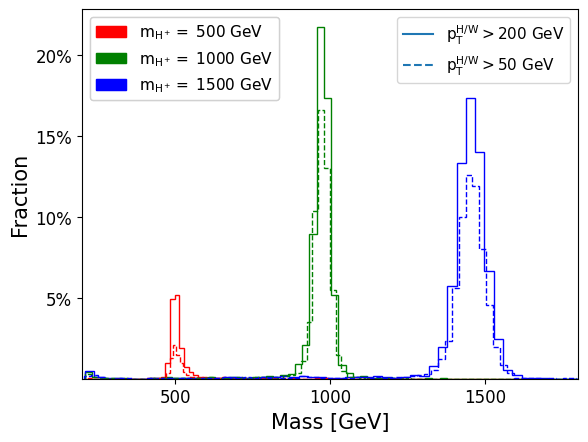

In [15]:
colors = ["r", "g", "b"]

for jet, color in zip(jets[:3], colors):
    masses = []
    for _, j in jet.items():
        higgs = j["higgs"]
        wboson = j["wzboson"]
        if higgs.shape[0] > 0 and wboson.shape[0] > 0:
            masses.append(calc_mass(kin2mom(higgs[0]) + kin2mom(wboson[0])))
    masses = np.concatenate(masses, 0)
    plt.hist(masses, 100, color=color, histtype="step", weights=np.ones((masses.shape[0],)) / 10000)
for jet, color in zip(jets[3:], colors):
    masses = []
    for _, j in jet.items():
        higgs = j["higgs"]
        wboson = j["wzboson"]
        if higgs.shape[0] > 0 and wboson.shape[0] > 0:
            masses.append(calc_mass(kin2mom(higgs[0]) + kin2mom(wboson[0])))
    masses = np.concatenate(masses, 0)
    plt.hist(masses, 100, linestyle="--", color=color, histtype="step", weights=np.ones((masses.shape[0],)) / 10000)

handles = [plt.Line2D([0], [0], linestyle=ls) for ls in ["-", "--"]]
legend = plt.gca().legend(handles, ["$\mathrm{p_T^{H/W}} > 200$ GeV", r"$\mathrm{p_T^{H/W}} > 50$ GeV"], loc='upper right', fontsize=11)
plt.gca().add_artist(legend)

handles = [plt.Rectangle((0, 0), 0, 0, color=c) for c in colors]
legend = plt.gca().legend(handles, [r"$\mathrm{m_{H^+}} =\ 500$ GeV", r"$\mathrm{m_{H^+}} =\ 1000$ GeV", r"$\mathrm{m_{H^+}} =\ 1500$ GeV"], loc='upper left', fontsize=11)
plt.gca().add_artist(legend)

# plt.ylim(0, 0.2)
plt.xlim(200, 1800)
plt.xticks([500, 1000, 1500], fontsize=12)
plt.yticks([0.05 * (i + 1) for i in range(4)], [f"{5 * (i + 1)}%" for i in range(4)], fontsize=12)
plt.ylabel("Fraction", fontsize=15)
plt.xlabel("Mass [GeV]", fontsize=15)
plt.savefig("reconst_hp.pdf", dpi=600, bbox_inches="tight", format="pdf")
plt.show()

# Jet 预测展示 #

In [1]:
import os
import math
import torch
import pickle
import numpy as np
from skimage import measure
from matplotlib import path as mpath
from matplotlib import pyplot as plt
from dataset_loader import DatasetLoader
from scipy.ndimage import gaussian_filter
from scipy.interpolate import splprep, splev
from generate_mask import calc_mass, calc_pt_rapidity_phi
from model import LhcSAM, calc_bbox, calc_mask_jaccard_metric
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes


@torch.no_grad()
def jet_detection(test_dir, batch_size=20, pretrain: str = None):
    lhc = LhcSAM(315, 5).cuda().eval()

    if pretrain is not None and os.path.exists(pretrain):
        state = torch.load(pretrain, weights_only=True)
        lhc.load_state_dict(state["lhc"])
        print("load epoch = [%d]" % state["epoch"])

    dataset = torch.utils.data.DataLoader(DatasetLoader(test_dir, n_mix=50, flat_prob=0.0), batch_size, True)

    jets = {}
    ro_jets = {}
    conf_threshold = 0.3
    for i, data in enumerate(dataset):
        image, prompt, mask_label, class_label, momentum_label = [dat.cuda() for dat in data]
        pred_conf, pred_mask, pred_class, pred_momentum = lhc([image, prompt])

        pred_mask = torch.sigmoid(pred_mask)
        pred_class = torch.argmax(pred_class, -1)
        pts, etas, phis = np.split(calc_pt_rapidity_phi(np.transpose(image.cpu().numpy(), [0, 2, 3, 1])), 3, -1)
        
        for j, (conf, mask, cls, gt_mask, gt_cls, pt, eta, phi) in enumerate(zip(pred_conf, pred_mask, pred_class, mask_label, class_label, pts, etas, phis)):
            top_gt = torch.where(gt_cls == 1, 1.0, 0.0)
            higgs_gt = torch.where(gt_cls == 2, 1.0, 0.0)
            wzboson_gt = torch.where(gt_cls == 3, 1.0, 0.0)
            bottom_gt = torch.where(gt_cls == 4, 1.0, 0.0)

            top_gt = gt_mask[top_gt == 1.0]
            higgs_gt = gt_mask[higgs_gt == 1.0]
            wzboson_gt = gt_mask[wzboson_gt == 1.0]
            bottom_gt = gt_mask[bottom_gt == 1.0]

            top_det = torch.where(torch.logical_and(conf > conf_threshold, cls == 1), 1.0, 0.0)
            higgs_det = torch.where(torch.logical_and(conf > conf_threshold, cls == 2), 1.0, 0.0)
            wzboson_det = torch.where(torch.logical_and(conf > conf_threshold, cls == 3), 1.0, 0.0)
            bottom_det = torch.where(torch.logical_and(conf > conf_threshold, cls == 4), 1.0, 0.0)

            top_det = mask[top_det == 1.0]
            higgs_det = mask[higgs_det == 1.0]
            wzboson_det = mask[wzboson_det == 1.0]
            bottom_det = mask[bottom_det == 1.0]

            index = np.where(pt > 0)
            point = np.stack([pt[index], eta[index], phi[index]], 0)

            top_gt, higgs_gt, wzboson_gt, bottom_gt = remove_overlap(top_gt, higgs_gt, wzboson_gt, bottom_gt)

            top_det1, higgs_det1, wzboson_det1, bottom_det1 = remove_overlap(top_det, higgs_det, wzboson_det, bottom_det, 1.0)
            jets[i * batch_size + j] = {"point": point, "top": [top_gt, top_det1], "higgs": [higgs_gt, higgs_det1], "wzboson": [wzboson_gt, wzboson_det1], "bottom": [bottom_gt, bottom_det1]}
            
            top_det2, higgs_det2, wzboson_det2, bottom_det2 = remove_overlap(top_det, higgs_det, wzboson_det, bottom_det, 0.1)
            ro_jets[i * batch_size + j] = {"point": point, "top": [top_gt, top_det2], "higgs": [higgs_gt, higgs_det2], "wzboson": [wzboson_gt, wzboson_det2], "bottom": [bottom_gt, bottom_det2]}

        print(f"\rstep: {i + 1}/{len(dataset)}", end="")

        if i + 1 == 50:
            break
    
    return jets, ro_jets


def remove_overlap(top, higgs, wzboson, bottom, threshold=0.1):
    wzboson_iou = calc_mask_jaccard_metric(wzboson[:, None], top[None])
    wzboson_mask = torch.all(wzboson_iou < threshold, -1)

    bottom_iou1 = calc_mask_jaccard_metric(bottom[:, None], top[None])
    bottom_iou2 = calc_mask_jaccard_metric(bottom[:, None], higgs[None])
    bottom_mask = torch.logical_and(torch.all(bottom_iou1 < threshold, -1), torch.all(bottom_iou2 < threshold, -1))
    
    wzboson = wzboson[wzboson_mask]
    bottom = bottom[bottom_mask]

    return top.cpu().numpy(), higgs.cpu().numpy(), wzboson.cpu().numpy(), bottom.cpu().numpy()


def smooth_contour(contour, sigma=1.0, n_interp=100):
    smoothed = gaussian_filter(contour, sigma=[sigma, 0], mode='wrap')
    tck, u = splprep(smoothed.T, u=None, s=0.0, per=1)[:2]
    u_new = np.linspace(u.min(), u.max(), n_interp)
    x_new, y_new = splev(u_new, tck, der=0)
    return np.column_stack((x_new, y_new))


def calc_common_tangents(c1x, c1y, c1r, c2x, c2y, c2r):
    dx = c2x - c1x
    dy = c2y - c1y
    d_sq = dx**2 + dy**2
    d = math.sqrt(d_sq)
    
    ux = dx / d
    uy = dy / d
    vx = -uy
    vy = ux

    tangents = []
    if abs(c1r - c2r) <= d:
        dr = c2r - c1r
        cos_theta = dr / d
        sin_theta = math.sqrt(1 - cos_theta**2)
        for sign in [1, -1]:
            s = sign * sin_theta
            
            p1x_prime = -c1r * cos_theta
            p1y_prime = -c1r * s
            p2x_prime = -c2r * cos_theta
            p2y_prime = -c2r * s
            
            p1x = c1x + p1x_prime * ux + p1y_prime * vx
            p1y = c1y + p1x_prime * uy + p1y_prime * vy
            p2x = c2x + p2x_prime * ux + p2y_prime * vx
            p2y = c2y + p2x_prime * uy + p2y_prime * vy
            tangents.append(((p1x, p1y), (p2x, p2y)))
            
    return tangents


def plot_detection(ax, jets, index, legend=True, scale=1.0, **kwargs):
    labels = [["top", "t"], ["higgs", "H"], ["wzboson", "W/Z"], ["bottom", "b"]]
    colors = [["#507936", "#49864D", "#799A64", "#91AE84"], ["#B32142", "#D80835", "#E9464D", "#B02E82"], ["#EDA01F", "#F1BD3F", "#DAA91F", "#ECD452"], ["#346C9C", "#2775B6", "#5698C3", "#93B5CF"]]
    
    ax.scatter(jets[index]["point"][1], jets[index]["point"][2], s=np.sqrt(jets[index]["point"][0]) * scale, color="gray", alpha=0.4)
    for label, color in zip(labels, colors):
        gts, _ = jets[index][label[0]]
        for i, gt in enumerate(gts):
            for contour in measure.find_contours(gt, 0.1):
                y, x = smooth_contour(contour, 1.0).T
                eta = np.interp(x, [0, gt.shape[1] - 1], [-np.pi, np.pi])
                phi = np.interp(y, [0, gt.shape[0] - 1], [0, 2 * np.pi])
                ax.plot(eta, phi, linewidth=kwargs["linewidth"], color=color[i], linestyle="-")
    
    for label, color in zip(labels, colors):
        _, dets = jets[index][label[0]]
        for i, det in enumerate(dets):
            for contour in measure.find_contours(det, 0.1):
                y, x = smooth_contour(contour, 1.0).T
                eta = np.interp(x, [0, det.shape[1] - 1], [-np.pi, np.pi])
                phi = np.interp(y, [0, det.shape[0] - 1], [0, 2 * np.pi])
                ax.plot(eta, phi, linewidth=kwargs["linewidth"], color=color[i], linestyle="--")

    if legend:
        handles = []
        for label, color in zip(labels, colors):
            handles.append(plt.Rectangle((0, 0), 1, 1, linewidth=0.0, facecolor=color[0], edgecolor=color[0], label=label[1]))
            handles.append(plt.Line2D([0], [0], marker='None', color='None', linestyle='None', label=''))
        ax.add_artist(ax.legend(handles=handles, fontsize=12, framealpha=0.5, loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=4))
        handles = []
        handles.append(plt.Line2D([], [], linewidth=1.0, color='black', linestyle="-", label=f'Truth'))
        handles.append(plt.Line2D([], [], linewidth=1.0, color='black', linestyle="--", label=f'Prediction'))
        ax.add_artist(ax.legend(handles=handles, fontsize=12, framealpha=0.5, loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2, frameon=False))

/home/rzhang/miniconda3/envs/lhcSAM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
jets, ro_jets = jet_detection("htt", 20, "./result/state.pth")

In [ ]:
with open("jets.pkl", "wb") as file:
    pickle.dump([jets, ro_jets], file)

In [2]:
with open("jets.pkl", "rb") as file:
    jets, ro_jets = pickle.load(file)

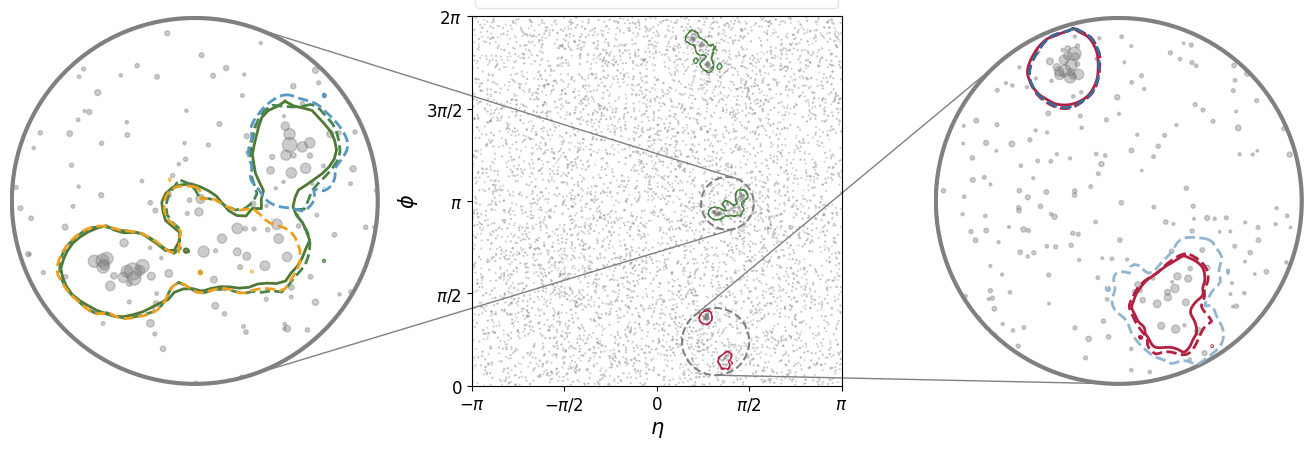

In [3]:
index = 282 # np.random.randint(0, 1000)
src1_x, src1_y, src1_r = 1.2, 3.1, np.pi / 7
dst1_x, dst1_y, dst1_r = -2.5 * np.pi, np.pi, np.pi

src2_x, src2_y, src2_r = 1.0, 0.75, np.pi / 5.5
dst2_x, dst2_y, dst2_r = 2.5 * np.pi, np.pi, np.pi

ax = plt.gca()
axins1 = zoomed_inset_axes(ax, dst1_r / src1_r, loc="center", bbox_transform=ax.transAxes, bbox_to_anchor=((dst1_x + np.pi) / (2 * np.pi), dst1_y / (2 * np.pi)))
axins2 = zoomed_inset_axes(ax, dst2_r / src2_r, loc="center", bbox_transform=ax.transAxes, bbox_to_anchor=((dst2_x + np.pi) / (2 * np.pi), dst2_y / (2 * np.pi)))

src1_circle = plt.Circle((src1_x, src1_y), src1_r, fc='none', ec='gray', lw=1.5, linestyle='--')
src2_circle = plt.Circle((src2_x, src2_y), src2_r, fc='none', ec='gray', lw=1.5, linestyle='--')
dst1_circle = plt.Circle((0.5, 0.5), 0.495, transform=axins1.transAxes, fc='white', ec="gray", lw=3)
dst2_circle = plt.Circle((0.5, 0.5), 0.495, transform=axins2.transAxes, fc='white', ec="gray", lw=3)

plot_detection(ax, ro_jets, index, scale=0.5, linewidth=1.0)

ax.add_patch(src1_circle)
ax.add_patch(src2_circle)
tangents1 = calc_common_tangents(src1_x, src1_y, src1_r, dst1_x, dst1_y, dst1_r * 0.99)
tangents2 = calc_common_tangents(src2_x, src2_y, src2_r, dst2_x, dst2_y, dst2_r * 0.99)
ax.plot((tangents1[0][0][0], tangents1[0][1][0]), (tangents1[0][0][1], tangents1[0][1][1]), c="gray", lw=1, clip_on=False)
ax.plot((tangents1[1][0][0], tangents1[1][1][0]), (tangents1[1][0][1], tangents1[1][1][1]), c="gray", lw=1, clip_on=False)
ax.plot((tangents2[0][0][0], tangents2[0][1][0]), (tangents2[0][0][1], tangents2[0][1][1]), c="gray", lw=1, clip_on=False)
ax.plot((tangents2[1][0][0], tangents2[1][1][0]), (tangents2[1][0][1], tangents2[1][1][1]), c="gray", lw=1, clip_on=False)

ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(0.0, 2 * np.pi)
ax.set_aspect('equal', 'box')
ax.set_xlabel(r"$\eta$", fontsize=15)
ax.set_ylabel(r"$\phi$", fontsize=15)
ax.set_xticks([-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi], [r"$-\pi$", r"$-\pi/2$", "$0$", r"$\pi/2$", r"$\pi$"], fontsize=12)
ax.set_yticks([0, np.pi / 2, np.pi, 1.5 * np.pi, 2 * np.pi], ["$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"], fontsize=12)

axins1.add_patch(dst1_circle)
axins2.add_patch(dst2_circle)
plot_detection(axins1, jets, index, False, dst1_r / src1_r * 2.0, linewidth=2.0)
plot_detection(axins2, jets, index, False, dst2_r / src2_r * 2.0, linewidth=2.0)

for artist in axins1.lines + axins1.collections + axins1.patches:
    if artist is not dst1_circle:
        artist.set_clip_path(dst1_circle)
for artist in axins2.lines + axins2.collections + axins2.patches:
    if artist is not dst2_circle:
        artist.set_clip_path(dst2_circle)

axins1.set_frame_on(False)
axins1.set_aspect('equal', adjustable='box')
axins1.set_xlim(src1_x - src1_r, src1_x + src1_r)
axins1.set_ylim(src1_y - src1_r, src1_y + src1_r)
axins1.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)

axins2.set_frame_on(False)
axins2.set_aspect('equal', adjustable='box')
axins2.set_xlim(src2_x - src2_r, src2_x + src2_r)
axins2.set_ylim(src2_y - src2_r, src2_y + src2_r)
axins2.tick_params(labelleft=False, labelbottom=False, left=False, bottom=False)

plt.savefig("jet.pdf", dpi=300, bbox_inches="tight", format="pdf")
plt.show()